In [27]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_excel("NHL All Time Point Leaders Feb 20 2024.xlsx")
df.head()

,Rk,Name,Born,Pos,GP,G,A,P,PIM,+/-,...,G/GP,A/GP,P/GP,SHOTS,SH%,HITS,BS,FOW,FOL,FO%
0,1,Wayne Gretzky,1961,F,1487,894,1963,2857,577,520.0,...,0.601,1.320,1.921,5083.0,17.6%,NaN,NaN,1199.0,1249.0,48.98%
1,2,Jaromír Jágr,1972,F,1733,766,1155,1921,1167,322.0,...,0.442,0.666,1.108,5637.0,13.6%,187.0,114.0,12.0,37.0,24.49%
2,3,Mark Messier,1961,F,1756,694,1193,1887,1912,211.0,...,0.395,0.679,1.075,4221.0,16.4%,NaN,NaN,5743.0,4755.0,54.71%
3,4,Gordie Howe,1928,F,1767,801,1049,1850,1685,160.0,...,0.453,0.594,1.047,3803.0,0.0%,NaN,NaN,NaN,NaN,NaN
4,5,Ron Francis,1963,F,1731,549,1249,1798,977,-18.0,...,0.317,0.722,1.039,3756.0,14.6%,NaN,NaN,4773.0,3940.0,54.78%


# Part 1: Data Cleaning

In [28]:
# Step 1: Handle missing values -> Fill in numericals NaN columns with 0
num_cols = df.select_dtypes(include=['number']).columns
df[num_cols] = df[num_cols].fillna(0)

# Step 2: Ensuring correct data types
df['Born'] = df['Born'].astype(int)  
df['Pos'] = df['Pos'].astype(str) 

# Step 3: Convert percentage columns to numerical columns
for col in df.columns:
    if df[col].dtype == 'object' and df[col].str.contains('%', na=False).any():
        df[col] = df[col].str.replace('%', '', regex=True).astype(float)

df.head()

,Rk,Name,Born,Pos,GP,G,A,P,PIM,+/-,...,G/GP,A/GP,P/GP,SHOTS,SH%,HITS,BS,FOW,FOL,FO%
0,1,Wayne Gretzky,1961,F,1487,894,1963,2857,577,520.0,...,0.601,1.320,1.921,5083.0,17.6,0.0,0.0,1199.0,1249.0,48.98
1,2,Jaromír Jágr,1972,F,1733,766,1155,1921,1167,322.0,...,0.442,0.666,1.108,5637.0,13.6,187.0,114.0,12.0,37.0,24.49
2,3,Mark Messier,1961,F,1756,694,1193,1887,1912,211.0,...,0.395,0.679,1.075,4221.0,16.4,0.0,0.0,5743.0,4755.0,54.71
3,4,Gordie Howe,1928,F,1767,801,1049,1850,1685,160.0,...,0.453,0.594,1.047,3803.0,0.0,0.0,0.0,0.0,0.0,NaN
4,5,Ron Francis,1963,F,1731,549,1249,1798,977,-18.0,...,0.317,0.722,1.039,3756.0,14.6,0.0,0.0,4773.0,3940.0,54.78


# Part 2: Exploratory Data Analysis

In [29]:
# Summary Statistics
position_summary = df['Pos'].value_counts(normalize=True) * 100
summ_stats = df[['G', 'A', 'P', 'SHOTS', 'SH%', 'PIM', 'FOW', 'FO%']].describe().drop('count')
pos_stats = df.groupby("Pos")[['G', 'A', 'P', 'SHOTS', 'PIM', 'FOW', 'FO%']].mean()
print("Basic Summary Statistics:\n\n", summ_stats.round(2), "\n\n")
print("Position Based Summary Statistics:\n\n", pos_stats.round(2))
print(f"\nForwards make up {position_summary.get('F', 0):.2f}% of the top 1000 all time scorers.")
print(f"Defensemen make up {position_summary.get('D', 0):.2f}% of the top 1000 all time scorers.")

Basic Summary Statistics:

            G        A        P    SHOTS    SH%      PIM       FOW     FO%
mean  240.72   374.94   615.66  1924.66  11.22   651.49   1207.53   40.69
std   125.97   181.89   283.15   943.89   4.47   508.36   2519.50   18.02
min    43.00    89.00   332.00     0.00   0.00    24.00      0.00    0.00
25%   159.00   255.00   415.75  1360.00   8.90   303.00      0.00   34.77
50%   211.00   328.00   530.50  1774.00  12.10   506.50      2.00   44.76
75%   288.00   435.25   722.25  2395.00  14.10   825.50    676.50   50.00
max   894.00  1963.00  2857.00  6768.00  23.70  3971.00  15351.00  100.00 


Position Based Summary Statistics:

           G       A       P    SHOTS     PIM      FOW    FO%
Pos                                                         
D    127.06  404.95  532.01  1973.85  855.82     1.36  26.98
F    266.69  368.09  634.78  1913.41  604.80  1483.14  44.39

Forwards make up 81.40% of the top 1000 all time scorers.
Defensemen make up 18.60% of the top 

In [30]:
# Scoring Statistics Over Time

# Estimate when the players started their career -> Only birth year is provided in the dataset
df["Debut_Year"] = df["Born"] + 20  # We estimate that most careers started at age 20
df["Retire_Year"] = df["Debut_Year"] + (df["GP"] / 82)  # We say that the average season was 82 games

# Now we find the decades in which they were playing
df['Decade'] = ((df["Debut_Year"] //10) * 10).astype(int)

# Display results
decade_stats = df.groupby("Decade")[["G", "A", "P"]].mean().reset_index()
print("\nScoring Trends Over Decades:\n")
print(decade_stats.round(2).to_string(index=False))


Scoring Trends Over Decades:

 Decade      G      A      P
   1910 237.50 113.50 351.00
   1920 215.73 207.45 423.18
   1930 193.86 254.10 447.95
   1940 230.74 331.09 561.83
   1950 254.20 377.80 632.00
   1960 242.19 372.42 614.62
   1970 243.40 365.45 608.85
   1980 265.14 430.62 695.76
   1990 245.43 387.78 633.21
   2000 235.84 378.98 614.82
   2010 209.49 329.46 538.94
   2020 119.67 225.67 345.33


In [31]:
# Distribution of Points per Game
df['P/GP'] = df['P'] / df['GP']
df['P/GP'] = df['P/GP'].replace([float('inf'), -float('inf')], 0).fillna(0)
pdesc = df['P/GP'].describe().drop('count')
pdesc.name = None
print("Points per Game Summary Stats:\n")
print(pdesc.to_string())

Points per Game Summary Stats:

mean    0.682681
std     0.202786
min     0.279279
25%     0.540177
50%     0.653937
75%     0.795146
max     1.921318


In [32]:
# Assist per Game Leaders
df['AST/G'] = df['A'] / df['GP'].replace(0, 1)
top_assists = df[['Name', 'AST/G']].sort_values(by='AST/G', ascending=False).head(10)
print("Top Players by Assists per Game:\n")
print(top_assists.to_string(index=False))

Top Players by Assists per Game:

           Name    AST/G
  Wayne Gretzky 1.320108
  Mario Lemieux 1.128962
 Connor McDavid 1.002882
      Bobby Orr 0.981735
 Peter Forsberg 0.898305
   Quinn Hughes 0.813107
  Peter Stastny 0.807574
     Adam Oates 0.807031
    Paul Coffey 0.805536
Mitchell Marner 0.793651


In [33]:
# 8. Goal to Assist Ratio Analysis
df['G/A Ratio'] = df['G'] / df['A'].replace(0, 1)  
print("Top Players by G/A Ratio:\n")
top_ga = df[['Name', 'G/A Ratio']].sort_values(by='G/A Ratio', ascending=False).head(10)
print(top_ga.to_string(index=False))

Top Players by G/A Ratio:

            Name  G/A Ratio
      Cy Denneny   2.775281
    Nels Stewart   1.696335
       Bill Cook   1.652174
    Wendel Clark   1.410256
   Aurele Joliat   1.386598
Blaine Stoughton   1.350785
      Anders Lee   1.341232
    Reggie Leach   1.336842
    Howie Morenz   1.321951
       Cam Neely   1.321070


# Part 3: Data Visualization

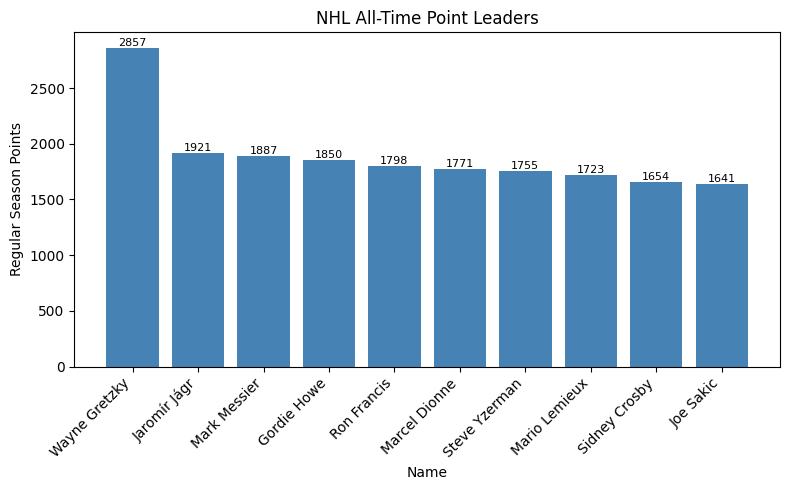

In [34]:
# All Time Point Leaders
top10 = df.sort_values(by='P', ascending=False).head(10)
plt.figure(figsize=(8,5))
bars = plt.bar(top10['Name'], top10['P'], color='steelblue')
plt.title('NHL All-Time Point Leaders')
plt.xlabel('Name')
plt.ylabel('Regular Season Points')
plt.xticks(rotation=45, ha='right')

# Add labels on top of bars
for i in bars:
    yval = i.get_height()
    plt.text(i.get_x() + i.get_width()/2.0, yval, int(yval), va='bottom', ha='center', fontsize=8)

plt.tight_layout()
plt.show()

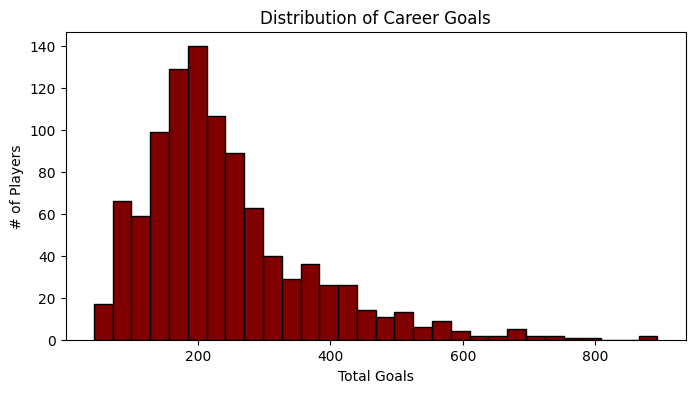

In [35]:
# Goal Distributions
plt.figure(figsize=(8,4))
plt.hist(df['G'], bins=30, color='Maroon', edgecolor='black')
plt.title('Distribution of Career Goals')
plt.xlabel('Total Goals')
plt.ylabel('# of Players')
plt.show()

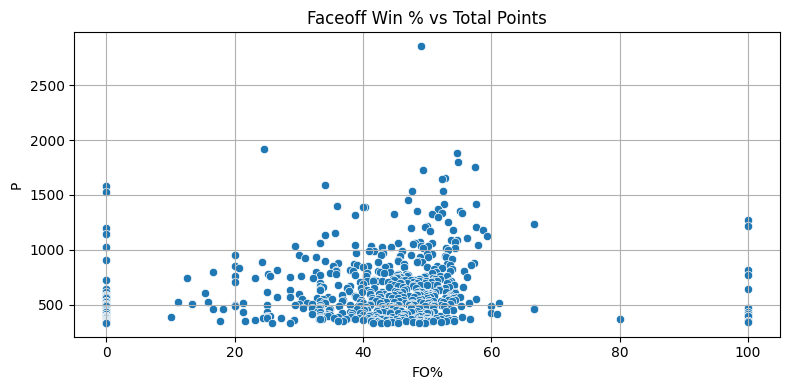

In [36]:
# Faceoff Win % vs Total Points
plt.figure(figsize=(8,4))
sns.scatterplot(data=df, x='FO%', y='P')
plt.title('Faceoff Win % vs Total Points')
plt.grid(True)
plt.tight_layout()
plt.show()

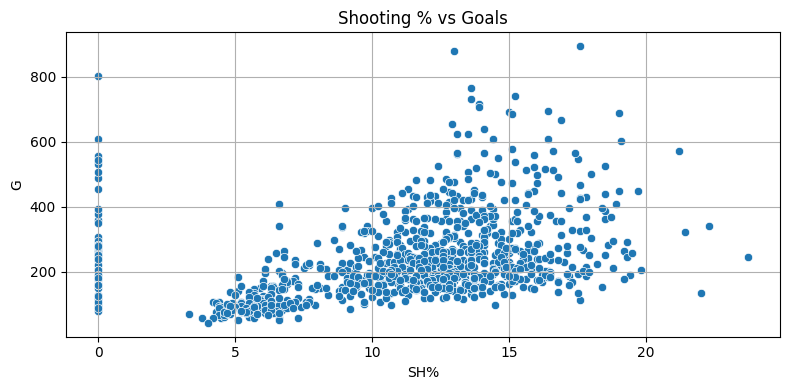

In [37]:
# Shooting % vs Goals
plt.figure(figsize=(8,4))
sns.scatterplot(data=df, x='SH%', y='G')
plt.title('Shooting % vs Goals')
plt.grid(True)
plt.tight_layout()
plt.show()

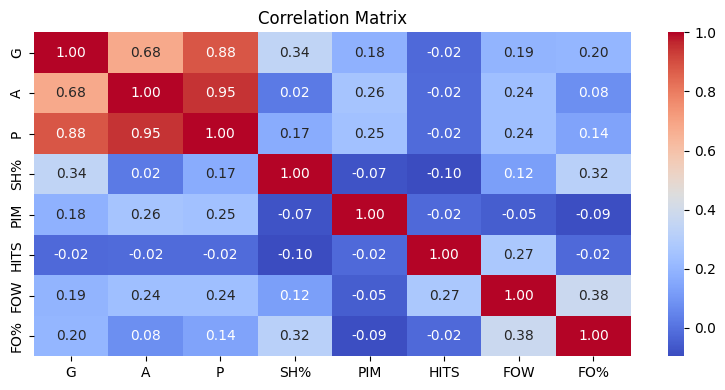

In [38]:
# Correlation Matrix
plt.figure(figsize=(8,4))
correlation_matrix = df[['G','A','P','SH%','PIM','HITS','FOW','FO%']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# Part 4: Linear Regression

We want to predict total points based on hits, PIM, shooting %, and faceoff %

In [39]:
sec = df[['SH%', 'FO%', 'HITS', 'PIM']].fillna(0)
model = LinearRegression()
model.fit(sec, df['P'])
r_squared = model.score(sec, df['P'])

print("Intercept:", round(model.intercept_, 2))
print("Coefficients:")
for sec, coef in zip(sec.columns, model.coef_):
    print(f"  {sec}: {round(coef, 2)}")
print(f"R-squared: {round(r_squared, 3)}")

Intercept: 384.27
Coefficients:
  SH%: 10.34
  FO%: 1.61
  HITS: -0.03
  PIM: 0.14
R-squared: 0.12
